# Area Var

Notebook to explore population distrubtions across sub-national units by gridded population dataset

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt

In [2]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split, add = None):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
        add = additional custom stats function must be a dict {'mymean':mymean} (see rasterstats documentation)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, add_stats = add, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        if add == None:
            zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
            polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
        
        else:
            key = list(add.keys())[0]
            zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
            zgdf = zgdf.rename(columns={key: data+'_'+key})
            polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type, data+'_'+key]], on = col, how = 'inner')
    
    return polys_out

In [3]:
def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

In [43]:
def make_data(polys_fn, rst_fns, GID_col, stats_type, split_str, add_dic):
    
    """ Finds area of polygons and then runs zonal statistics on them across gridded population rasters
    Args:
        polys_fn = path and file name of polygons (gdam usually)
        rst_fns = glob list of raster names for zonal stats
        GID_col = column of gdam level 
        stats_type = see zone_loop
        split_str = see zone_loop
        add_dic = see zone_loop
    """
    
    # open polys
    polys = gpd.read_file(polys_fn)
    
    # calculate area
    polys['area'] =  polys.to_crs('EPSG:3857').area
    
    # zonal stats
    polys_zone = polys[['geometry', GID_col]]
    polys_final = zone_loop(polys_in = polys_zone, rst_list = rst_fns, stats_type = stats_type, col = GID_col, 
                         split = split_str, add = add_dic)
    
    # merge
    df_out = polys_final.merge(polys[[GID_col, 'area']], on = GID_col, how = 'inner')
    
    return df_out


In [62]:
def make_plot(data, x_col, y_col, custom_xlim, custom_ylim, label = None):
    
    """Makes a 1 by five plot -- need to update titles and what not
    Args:
        data = df_out from make_data
        x_col = x_column you want to plot
        y_col = y_column you want to plat by gridded product
        xlim = (min, max)
        ylim = (min, max)
        label = urban/rural
    """
    
    # set colors
    ESRI16_c = 'blue'
    GHS15_c = 'indigo'
    GWPv4_c = 'deeppink'
    LS15_c = 'deepskyblue'
    WP16_c = 'forestgreen'
    
    # Plot
    fig, axs = plt.subplots(5, 1, figsize = (5, 16), sharex=True)
    ws = 0.25
    fig.subplots_adjust(wspace=ws)

    axs[0].scatter(np.log10(data[x_col]), data['ESRI16_'+y_col], color = ESRI16_c, alpha = 0.5, s = 30, marker = '.')
    axs[1].scatter(np.log10(data[x_col]), data['GHS15_'+y_col], color = GHS15_c, alpha = 0.5,s = 30, marker = '.')
    axs[2].scatter(np.log10(data[x_col]), data['GPWv4_'+y_col], color = GWPv4_c,  alpha = 0.5, s = 30, marker = '.')
    axs[3].scatter(np.log10(data[x_col]), data['LS15_'+y_col], color = LS15_c, alpha = 0.5, s = 30, marker = '.')
    axs[4].scatter(np.log10(data[x_col]), data['WP16_'+y_col], color = WP16_c, alpha = 0.5, s = 30, marker = '.')

    # Titles
    axs[0].set_title('WPE-16', size = 12)
    axs[1].set_title('GHS-15', size = 12)
    axs[2].set_title('GWPv4-15', size = 12)
    axs[3].set_title('LS-15', size = 12)
    axs[4].set_title('WP-16', size = 12)
    axs[4].set_xlabel('Admin Level 4 Area [log10]', fontsize = 15)
    axs[2].set_ylabel('Std of pixel-level population '+label, fontsize = 15)

    # lims
    #plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim);

## Start with Nepal

In [23]:
# Data paths
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [58]:
# custom stats for zonal stats
def std(X):
    return np.std(X)

#args
add_dic = {'std':std}
geog = ''
split_str = '_all_Nepal.tif'
npl4_fn = DATA_PATH+'raw/GDAM/gadm36_NPL_shp/gadm36_NPL_3.shp'
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*'+split_str))
col = 'GID_3'

In [59]:
# run it
NPL = make_data(polys_fn = npl4_fn, rst_fns = rst_fns, GID_col = col, 
                stats_type = 'sum', split_str = split_str, add_dic = add_dic)

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


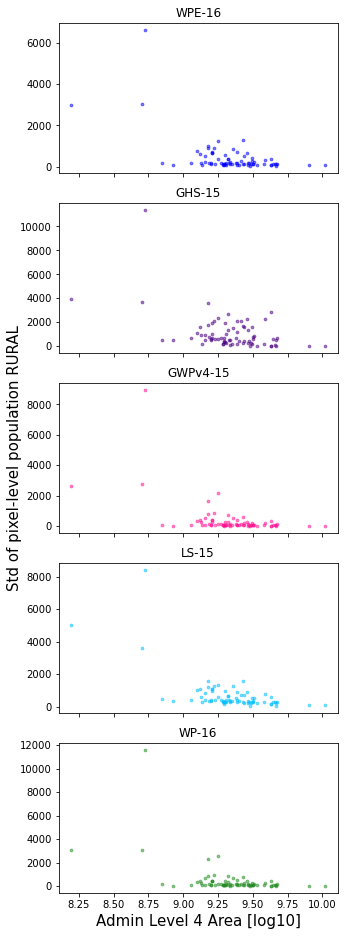

In [63]:
# def make_plot(data, x_col, custom_xlim, custom_ylim, label = None):
make_plot(data = NPL, x_col = 'area', y_col = 'std', custom_xlim = (6,9), custom_ylim = (- 100,20000), label = 'RURAL')